In [2]:
%matplotlib inline


# BRAINSTAT Tutorial 

### --------------------------------
###  1. Load sample dataset
### --------------------------------

In [3]:
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.tutorial.utils import fetch_mics_data

# Load behavioral markers
thickness, demographics = fetch_mics_data()
pial_left, pial_right = fetch_template_surface("fsaverage5", join=False)
pial_combined = fetch_template_surface("fsaverage5", join=True)
mask = fetch_mask("fsaverage5")

### ----------------------------------------------------------------------
###  2. Plot cortical thickness using the ENIGMA Toolbox
### ----------------------------------------------------------------------


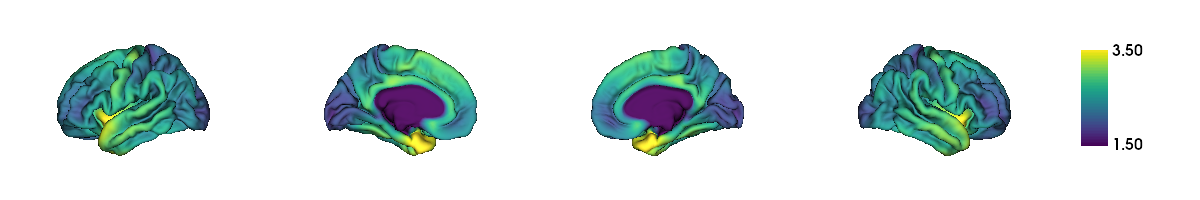

In [4]:
import numpy as np
from enigmatoolbox.plotting import plot_cortical

plot_cortical(array_name=np.mean(thickness, axis=0), surface_name="fsa5", size=(1200, 200),
              cmap='viridis', color_bar=True, color_range=(1.5, 3.5),
              embed_nb=True, interactive=False)

### -------------------------------------
###  3. Print demographics data
### -------------------------------------

In [5]:
print(demographics)

    SUB_ID  VISIT  AGE_AT_SCAN SEX
0   031404      1           27   F
1   04a144      1           25   M
2   0b78f1      1           33   M
3   0d26b9      1           36   F
4   1988b8      1           31   M
..     ...    ...          ...  ..
77  f25714      1           30   F
78  f25714      2           33   F
79  f615a5      1           26   F
80  feac6b      1           26   F
81  feac6b      2           29   F

[82 rows x 4 columns]


### ------------------------------------------------------------------------------------
###  4. Create linear model to assess the effect of age on thickness
### ------------------------------------------------------------------------------------

In [6]:
from brainstat.stats.terms import FixedEffect

term_age = FixedEffect(demographics.AGE_AT_SCAN)
model = term_age
print(model)

    intercept  AGE_AT_SCAN
0           1           27
1           1           25
2           1           33
3           1           36
4           1           31
..        ...          ...
77          1           30
78          1           33
79          1           26
80          1           26
81          1           29

[82 rows x 2 columns]


### -------------------------
###  5. Fit linear model
### -------------------------

In [13]:
from brainstat.stats.SLM import SLM

contrast_age = demographics.AGE_AT_SCAN
slm_age = SLM(
    model,
    -contrast_age,
    surf="fsaverage5",
    mask=mask,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
)
slm_age.fit(thickness)

### ------------------------------
###  6. Plot t- and p-values
### ------------------------------

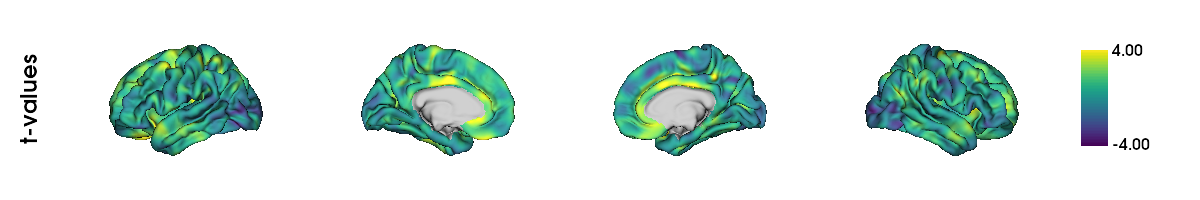

In [14]:
plot_cortical(array_name=slm_age.t, surface_name="fsa5", size=(1200, 200),
              cmap='viridis', color_bar=True, color_range=(-4, 4), nan_color=(0.7, 0.7, 0.7, 1),
              embed_nb=True, interactive=False, label_text=["t-values"])

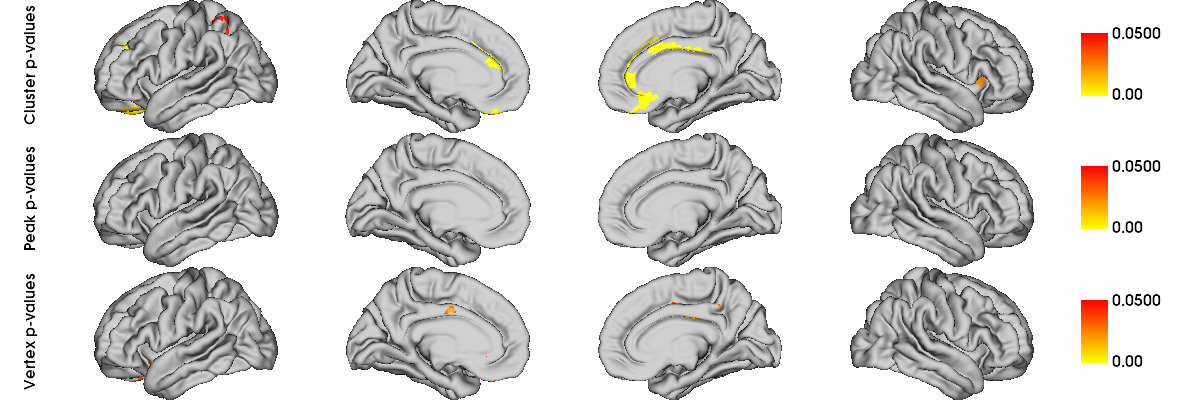

In [15]:
cp = [np.copy(slm_age.P["pval"]["C"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in cp]

pp = [np.copy(slm_age.P["pval"]["P"])]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in pp]

qp = [np.copy(slm_age.Q)]
[np.place(x, np.logical_or(x > 0.05, ~mask), np.nan) for x in qp]

vals = np.vstack([cp[0].T, pp[0].T, qp[0].T])
plot_cortical(array_name=vals, surface_name="fsa5", size=(1200, 400), zoom=1.8,
              cmap='autumn_r', color_bar=True, color_range=(0, 0.05), nan_color=(0.7, 0.7, 0.7, 1),
              embed_nb=True, interactive=False, label_text=["Cluster p-values", "Peak p-values", "Vertex p-values"])

### -----------------------------------
###  7. Meta-analytic decoding
### -----------------------------------

In [ ]:
from brainstat.context.meta_analysis import meta_analytic_decoder

meta_analysis = meta_analytic_decoder("fsaverage5", slm_age.t.flatten())
print(meta_analysis)

2022-10-19 13:35:28,614 - brainstat - INFO - Fetching Neurosynth feature files. This may take several minutes if you haven't downloaded them yet.
2022-10-19 13:35:28,742 - brainstat - INFO - Running correlations with all Neurosynth features.


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(background_color="white", random_state=0)
wc.generate_from_frequencies(frequencies=meta_analysis.to_dict()["Pearson's r"])
plt.imshow(wc)
plt.axis("off")
plt.show()